# Reinforcement Learning
## SoS, 2021
### Aayush Kakade

This notebook is the about the algorithms used to implement Reinforcement Learning in the game of EASY21.

#### **Easy21 rules:**


*   The game is played with an infinite deck of cards (i.e. cards are sampled with replacement)
*   Each draw from the deck results in a value between 1 and 10 (uniformly distributed) with a colour of red (probability 1/3) or black (probability 2/3).
* There are no aces or picture (face) cards in this game
* At the start of the game both the player and the dealer draw one black card (fully observed)
* Each turn the player may either **stick** or **hit**
* If the player hits then he draws another card from the deck
* If the player sticks he receives no further cards
* The values of the player’s cards are added (black cards) or subtracted (red cards)
* If the player’s sum exceeds 21, or becomes less than 1, then he “goes bust” and loses the game (reward -1)
* If the player sticks then the dealer starts taking turns. The dealer always sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome – win (reward +1), lose (reward -1), or draw (reward 0) – is the player with the largest sum.







## Importing necessary libraries and modules




In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from copy import deepcopy
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

## Setting up the environment

Defining our envronment where our agent can learn which action to pick in a given state in order to beat the dealer.

In [ ]:
class Easy21():
  
    def __init__(self):
      """
      This is the initial state where a random card is picked for the dealer and the player
      """
      dealer_score, _ = self.draw_card()
      player_score, _ = self.draw_card()

      self.state = {'dealer_score': dealer_score, 'player_score': player_score} # Initial state
      self.actions = ('hit','stick')

      initial_state = self.state.copy() # This copies the game history, state, reward and action for each step
      self.history = [initial_state]

    
    def step(self, state, action):
      """
      This function helps our player to compute the next step in the game
      
      Parameters:-
      state: the current state
      action: the action to pick
      """
      self.history.append({'player': action})

      if action == 'hit':
        value, colour = self.draw_card()
        self.state['player_score'] = self.compute_new_score(value, colour, current_score = self.state['player_score'])

        new_state = self.state.copy()

        if self.goes_bust(self.state['player_score']):
          reward = -1
          state = 'terminal'
          self.history.append(state)
          return state, reward
        else:
          reward = 0
          self.history.append(new_state)
          return self.state, reward
      else:
        new_state = self.state.copy()
        self.history.append(new_state)

        state, reward = self.dealer_moves()
        return state, reward
        """
        Returns:-
        state: new state
        reward: reward recieved in the new state        
        """  
    
    
    def draw_card(self):
      """
      This function is used to draw new card with the number and colour with probablities as per the rules of the game
      """
      value = random.randint(1,10)
      colour = ('red' if random.uniform(0,1) <= 1/3 else 'black')
      return value, colour

    
    def goes_bust(self, score):
      """
      This function tells if player/dealer goes bust
      """
      return ((score > 21) or (score < 1))

  
    def compute_new_score(self, value, colour, current_score):
      """
      This function computes the new score according to the new cards drawn
      """
      if colour == 'black':
        new_score = current_score + value
      else:
        new_score = current_score - value
    
      return new_score
  
    
    def dealer_moves(self):
      """
      This function executes the fixed dealer's policy as per the rules of the game
      """
      while self.state['dealer_score'] < 17:
        value, colour = self.draw_card()
        new_dealer_score = self.compute_new_score(value, colour, current_score = self.state['dealer_score'])
        self.state['dealer_score'] = new_dealer_score

        new_state = self.state.copy()
        self.history.append({'dealer': 'hit'})
        self.history.append(new_state)

        if self.goes_bust(new_dealer_score):
          reward = 1
          state = 'terminal'
          self.history.append(state)
          return state, reward
    
      self.history.append({'dealer': 'stick'})

      player_score = self.state['player_score']
      dealer_score = self.state['dealer_score']

      state = 'terminal'
      self.history.append(state)

      if dealer_score < player_score:
        reward = 1
        return state, reward
      if dealer_score == player_score:
        reward = 0
        return state, reward
      if dealer_score > player_score:
        reward = -1 
        return state, reward

Lets play a game of Easy21 to verify the environment implementation

In [ ]:
easy21_game = Easy21()
state_0 = easy21_game.state
state_1 = easy21_game.step(state_0, 'hit')[0]
state_2 = easy21_game.step(state=state_1, action='stick')
easy21_game.history

[{'dealer_score': 8, 'player_score': 5},
 {'player': 'hit'},
 'terminal',
 {'player': 'stick'},
 {'dealer_score': 8, 'player_score': -3},
 {'dealer': 'hit'},
 {'dealer_score': 14, 'player_score': -3},
 {'dealer': 'hit'},
 {'dealer_score': 11, 'player_score': -3},
 {'dealer': 'hit'},
 {'dealer_score': 15, 'player_score': -3},
 {'dealer': 'hit'},
 {'dealer_score': 14, 'player_score': -3},
 {'dealer': 'hit'},
 {'dealer_score': 20, 'player_score': -3},
 {'dealer': 'stick'},
 'terminal']

## Monte-Carlo Control

Monte-Carlo approach is just simply playing sample episodes or rounds of sequences our game.

Control here means that we are going to find the optimal policy to maximize our winning chances.

Using MCC approach, we start to sample an episode i.e play a game of Easy21 using a stratergy and analyse the reward of the terminal state

After the completion of our game, we simply update the Q value function of eacg state-action pair from our sampled episode regarding the reward obtained at the terminal state.

Once the Q value function gets updated, we can also review and update our strategy and we are ready for a new game with a new strategy.

In [ ]:
class MC_Control():
    
    def __init__(self, N_0, n_episodes):
      self.actions = ('hit', 'stick')
      self.N_0 = N_0
      self.n_episodes = n_episodes
      self.Q = self.init_to_zeros()
      self.N = self.init_to_zeros()
      self.policy = 'random'
    
    def learn_q_value_function(self):
      
      for i in range(self.n_episodes):
        episode = self.play_episode()
        self.policy = 'e_greedy'

        for step in episode:
          state, action, reward = step
          self.increment_counter(state, action)
          self.update_Q(state, action, reward)
      
      return self.Q
    
    def init_to_zeros(self):
      dealer_scores = np.arange(1,11)
      player_scores = np.arange(1,22)
      states = [(dealer_score, player_score) for player_score in player_scores for dealer_score in dealer_scores]
      lookup_table = {}

      for state in states:
        lookup_table[state] = {'hit': 0, 'stick': 0}
      
      return lookup_table
    
    def play_episode(self):
      easy21_game = Easy21()
      state = easy21_game.state.copy()
      episode=[]

      while state != 'terminal':
        if self.policy == 'random':
          action = self.random_policy()
        if self.policy == 'e_greedy':
          action = self.e_greedy_policy(state)
        next_state, reward = deepcopy(easy21_game.step(state, action))
        step = (state, action, reward)
        state = next_state
        episode.append(step)
      
      return episode
    
    def update_Q(self, state, action, reward):
      lookup_state = (state['dealer_score'], state['player_score'])
      alpha_t = 1/self.get_state_action_counter(state, action)
      self.Q[lookup_state][action] += alpha_t * (reward - self.Q[lookup_state][action])

      return None
    
    def increment_counter(self, state, action):
      lookup_state = (state['dealer_score'], state['player_score'])
      self.N[lookup_state][action] += 1
      return None
    
    def random_policy(self):
      action = random.choice(self.actions)
      return action
    
    def e_greedy_policy(self, state):
      e = self.N_0 / (self.N_0 + self.get_state_counter(state))

      if e > random.uniform(0,1):
        action = random.choice(self.actions)
      else:
        action = self.get_action_w_max_value(state)
      
      return action
    
    def get_action_w_max_value(self, state):
      lookup_state = (state['dealer_score'], state['player_score'])
      list_values = list(self.Q[lookup_state].values())
      if list_values[0] == list_values[1]:
        return self.random_policy()
      else:
        action = max(self.Q[lookup_state], key=self.Q[lookup_state].get)
        return action
    
    def get_state_counter(self, state):
      lookup_state = (state['dealer_score'], state['player_score'])
      counter = np.sum(list(self.N[lookup_state].values()))

      return counter
    
    def get_state_action_counter(self, state, action):
      lookup_state = (state['dealer_score'], state['player_score'])
      counter = self.N[lookup_state][action]

      return counter

### Optimal Q values
Now lets plot our Q value function for different number of episodes sampled for learning.

In [ ]:
def plot_Q(n_episodes):
    mc = MC_Control(N_0  =100, n_episodes = n_episodes)
    mc.learn_q_value_function()

    fig = plt.figure(figsize = (20,10))
    ax = fig.gca(projection = '3d')

    dealer_showing = np.arange(1,11)
    player_score = np.arange(1,22)
    dealer_showing, player_score = np.meshgrid(dealer_showing, player_score)

    max_Q = np.ndarray(shape=(21,10))

    for state in mc.Q:
      max_Q[state[1]-1][state[0]-1] = max(mc.Q[state].values())
    
    surf = ax.plot_surface(dealer_showing, player_score, max_Q, cmap = cm.coolwarm, linewidth=0, antialiased=False) 

    ax.set_zlim(-1.01,1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    plt.xlabel('Dealer showing', fontsize=12)
    plt.ylabel('Player score', fontsize=12)
    plt.title('Optimal Q value function', fontsize=16)

    plt.xticks(np.arange(1,11))
    plt.yticks(np.arange(1,22))

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

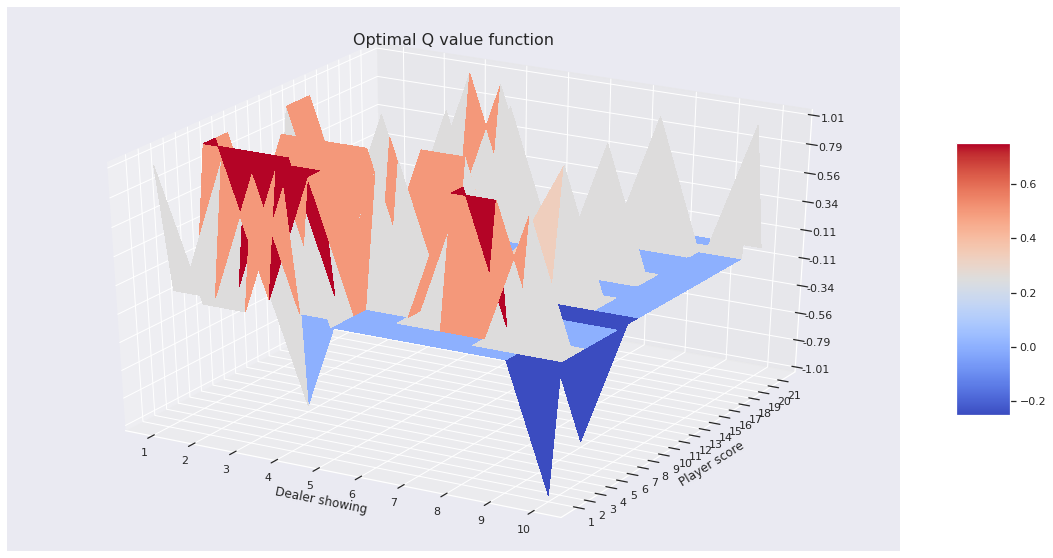

In [ ]:
plot_Q(n_episodes=100)

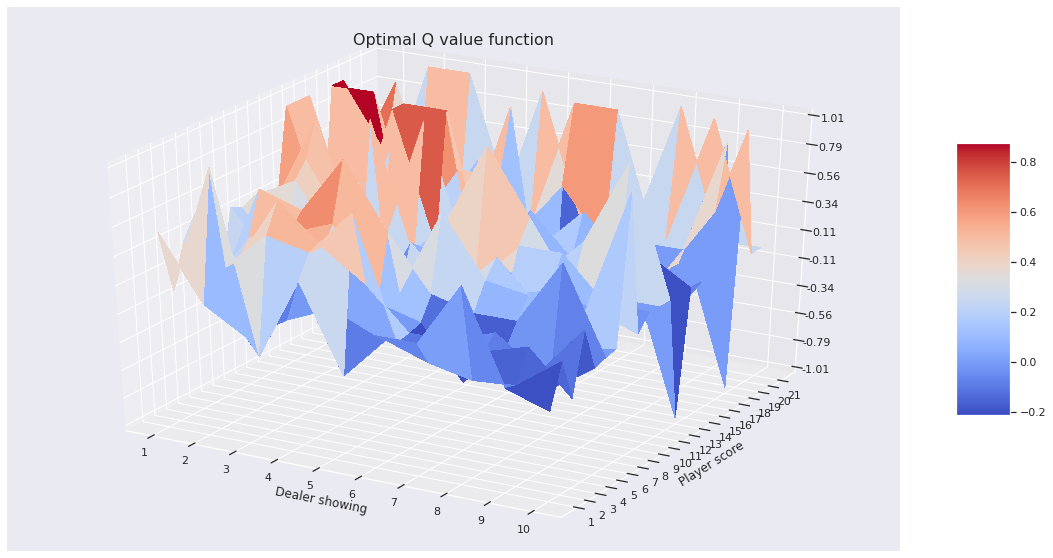

In [ ]:
plot_Q(n_episodes=1000)

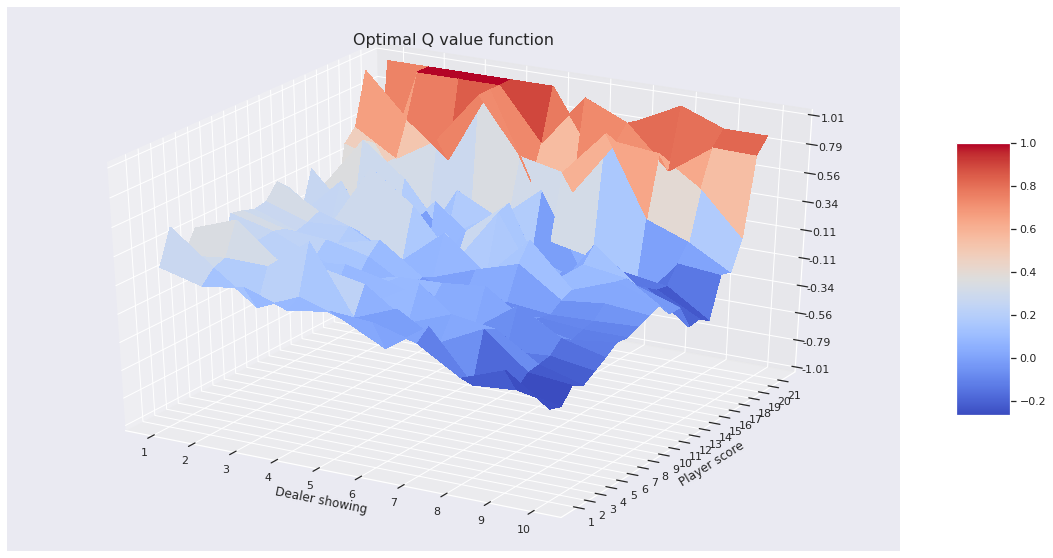

In [ ]:
plot_Q(n_episodes=10000)

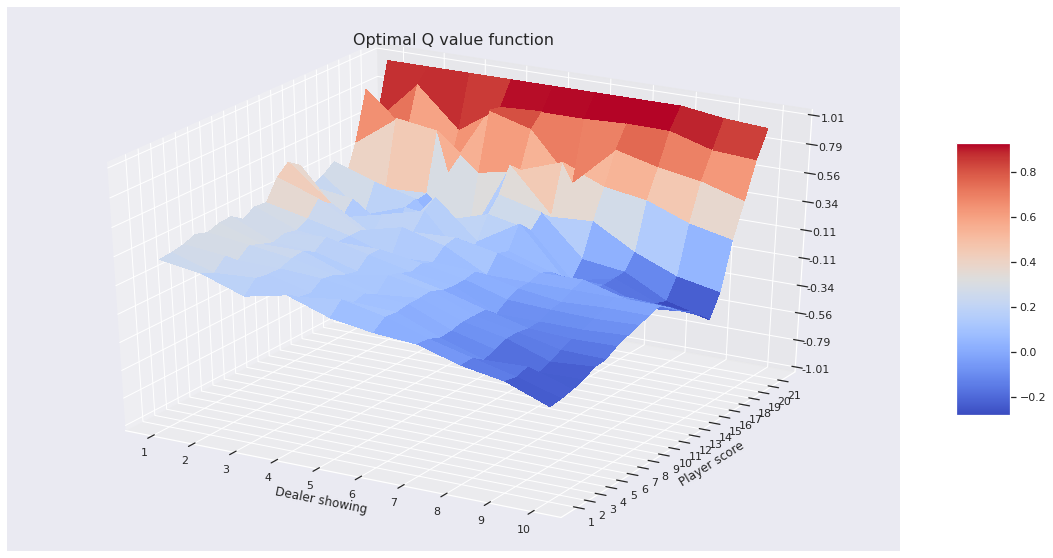

In [ ]:
plot_Q(n_episodes=100000)

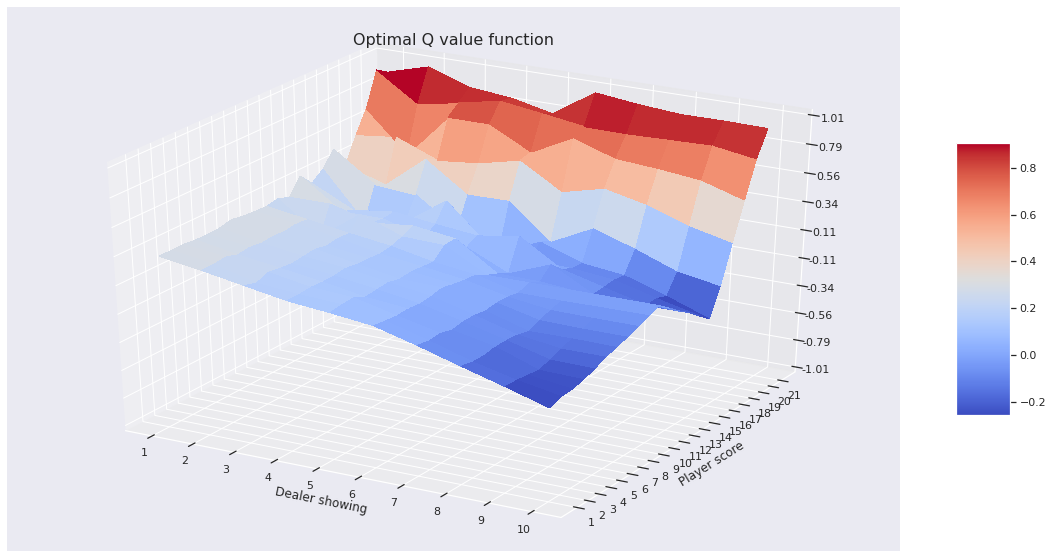

In [ ]:
plot_Q(n_episodes=1000000)

We can cleary see that the Q value function gets smoother and smoother when we play more number of games

### Optimal policy
Now lets see which action our agent will pick in different states after upadating our Q value function by playing a large number of games.

In [ ]:
def plot_opt_policy(n_episodes):
  mc = MC_Control(N_0=100, n_episodes=n_episodes)
  mc.learn_q_value_function()
  df = pd.DataFrame(columns=['dealer_showing', 'player_score', 'best_action'])
  states = list(mc.Q.keys())

  for i in range(len(states)):
    best_action = max(mc.Q[states[i]], key=mc.Q[states[i]].get)
    df.loc[i] = (states[i][0], states[i][1], best_action)

  df_pivot = df.pivot('player_score', 'dealer_showing', 'best_action')
  return df_pivot

In [ ]:
df = plot_opt_policy(n_episodes=1000)
df

dealer_showing,1,2,3,4,5,6,7,8,9,10
player_score,,,,,,,,,,
1,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
2,stick,stick,stick,stick,stick,stick,stick,hit,hit,stick
3,stick,hit,stick,hit,stick,stick,hit,stick,hit,hit
4,hit,stick,hit,hit,stick,stick,hit,hit,hit,stick
5,hit,stick,stick,stick,stick,hit,stick,stick,stick,stick
6,stick,stick,stick,stick,stick,stick,hit,stick,hit,hit
7,stick,stick,hit,hit,stick,stick,stick,hit,stick,hit
8,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
9,stick,hit,hit,stick,stick,stick,stick,hit,stick,hit


In [ ]:
df = plot_opt_policy(n_episodes=10000)
df

dealer_showing,1,2,3,4,5,6,7,8,9,10
player_score,,,,,,,,,,
1,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
2,stick,stick,stick,stick,stick,stick,stick,hit,stick,hit
3,stick,stick,stick,stick,stick,stick,stick,stick,hit,hit
4,stick,stick,stick,stick,stick,stick,stick,stick,hit,hit
5,stick,stick,stick,stick,stick,stick,stick,hit,hit,stick
6,stick,stick,stick,stick,stick,stick,stick,hit,hit,hit
7,stick,stick,stick,stick,stick,hit,stick,hit,hit,hit
8,stick,stick,stick,stick,stick,stick,hit,stick,stick,hit
9,stick,stick,stick,stick,hit,stick,hit,stick,hit,hit


In [ ]:
df = plot_opt_policy(n_episodes=100000)
df

dealer_showing,1,2,3,4,5,6,7,8,9,10
player_score,,,,,,,,,,
1,stick,stick,stick,stick,stick,stick,stick,stick,stick,hit
2,stick,stick,stick,stick,stick,stick,stick,stick,stick,hit
3,stick,stick,stick,stick,stick,stick,stick,stick,stick,hit
4,stick,stick,stick,stick,stick,stick,stick,stick,hit,hit
5,stick,stick,stick,stick,stick,stick,stick,stick,hit,hit
6,stick,stick,stick,stick,stick,stick,hit,stick,hit,hit
7,stick,stick,stick,stick,stick,stick,hit,stick,hit,hit
8,stick,stick,stick,stick,stick,stick,stick,stick,hit,hit
9,stick,stick,stick,stick,stick,stick,stick,hit,hit,hit


In [ ]:
df = plot_opt_policy(n_episodes=1000000)
df

dealer_showing,1,2,3,4,5,6,7,8,9,10
player_score,,,,,,,,,,
1,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
2,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
3,stick,stick,stick,stick,stick,stick,stick,stick,stick,hit
4,stick,stick,stick,stick,stick,stick,stick,stick,stick,hit
5,stick,stick,stick,stick,stick,stick,stick,stick,hit,hit
6,stick,stick,stick,stick,stick,stick,stick,hit,hit,hit
7,stick,stick,stick,stick,stick,stick,stick,hit,hit,hit
8,stick,stick,stick,stick,stick,stick,stick,hit,hit,hit
9,stick,stick,stick,stick,stick,stick,hit,hit,hit,hit


We can cleary see that the our agent knows the exact action to take in different states once we train the Q value function by playing a large number of games

## TD learning with SARSA(λ)
SARSA is State->Action->Reward->State->Action which is exactly the way the algorith updates the Q value function towards optimality. The λ is a model's parameter.

Temporal-Difference (TD) learning means that we are going to look at the Q value ne step in the future to update the current Q value towards this future Q estimation.

Hence, SARSA starts to learn from incomplete episodes and not at the end of the sampled episode like in MCC.

Eligibility Traces (ET): ET helps us to weight the Q value updates of every state-action pair regarding how frequent and how long ago the state-action pair has been seen at a given step of the episode.

The λ parameter or the trace factor specifies how fast the trac will fade away. λ exists in the range [0,1], the closer to zero means a faster fading and to 1 a slower one.

Rather than choosing between TD learning or Monte-Carlo sampling. SARSA(λ) uses the trace factor, scaling from 0 to 1, to combine the best of the two concepts.

In [ ]:
class SARSA():
    
    def __init__(self, lamb, n_episodes, N_0=100):
      self.actions = ('hit', 'stick')
      self.lamb = lamb
      self.n_episodes = n_episodes
      self.N_0 = N_0

      self.Q = self.init_to_zeros()
      self.N = self.init_to_zeros()

      self.Q_history = {}
      self.list_n_episodes = np.linspace(10, n_episodes-1, 30, dtype = int)
    
    def learn_q_value_function(self):
      for i in range(self.n_episodes):
        self.eligibility_traces = self.init_to_zeros()
        easy21_game = Easy21()
        state = easy21_game.state.copy()
        action = self.e_greedy_policy(state)
        self.increment_counter(state, action)

        while state != 'terminal':
          next_state, reward = deepcopy(easy21_game.step(state, action))

          if next_state == 'terminal':
            next_action = None
            delta = self.compute_delta(state, action, next_state, next_action, reward)

          else:
            next_action = self.e_greedy_policy(next_state)
            delta = self.compute_delta(state, action, next_state, next_action, reward)
            self.increment_counter(next_state, next_action)

          self.increment_eligibility_traces(state, action)
          self.update_step(delta)

          action = next_action
          state = next_state
        
        if i in self.list_n_episodes:
          self.Q_history[i] = deepcopy(self.Q)
      
      return self.Q
    
    def init_to_zeros(self):
      dealer_scores = np.arange(1,11)
      player_scores = np.arange(1,22)
      states = [(dealer_score, player_score) for player_score in player_scores for dealer_score in dealer_scores]
      lookup_table = {}
      for state in states:
        lookup_table[state] = {'hit': 0, 'stick': 0}
      
      return lookup_table
    
    def update_step(self, delta):
      for state in self.Q.keys():
        for action in self.actions:
          alpha = 1 / (self.get_state_action_counter(state, action) + 1)
          self.Q[state][action] += alpha * delta * self.eligibility_traces[state][action]
          self.eligibility_traces[state][action] *= self.lamb
      
      return None
    
    def compute_delta(self, state, action, next_state, next_action, reward):
      lookup_state = (state['dealer_score'], state['player_score'])

      if next_state == 'terminal':
        delta = reward - self.Q[lookup_state][action]
      else:
        next_lookup_state = (next_state['dealer_score'], next_state['player_score'])
        delta = reward + self.Q[next_lookup_state][next_action] - self.Q[lookup_state][action]
      
      return delta
    
    def increment_eligibility_traces(self, state, action):
      lookup_state = (state['dealer_score'], state['player_score'])
      self.eligibility_traces[lookup_state][action] += 1
      return None
    
    def increment_counter(self, state, action):
      lookup_state = (state['dealer_score'], state['player_score'])
      self.N[lookup_state][action] += 1
      return None
    
    def random_policy(self):
      action = random.choice(self.actions)
      return action
    
    def e_greedy_policy(self, state):
      e = self.N_0 / (self.N_0 + self.get_state_counter(state))
      if e > random.uniform(0,1):
        action = random.choice(self.actions)
      else:
        action = self.get_action_w_max_value(state)

      return action      
    
    def get_action_w_max_value(self, state):
      lookup_state = (state['dealer_score'], state['player_score'])
      list_values = list(self.Q[lookup_state].values())
      if list_values[0] == list_values[1]:
        return self.random_policy()
      else:
        action = max(self.Q[lookup_state], key = self.Q[lookup_state].get)
        return action

    def get_state_counter(self, state):
      lookup_state = (state['dealer_score'], state['player_score'])
      counter = np.sum(list(self.N[lookup_state].values()))
      return counter
    
    def get_state_action_counter(self, state, action):
      counter = self.N[state][action]
      return counter 

In [ ]:
sarsa = SARSA(lamb=0.9, n_episodes=100, N_0=100)
sarsa.learn_q_value_function()

{(1, 1): {'hit': 0.0, 'stick': 0.0},
 (1, 2): {'hit': 0.0, 'stick': 0.0},
 (1, 3): {'hit': -0.45, 'stick': -0.5},
 (1, 4): {'hit': 0.0, 'stick': 0.5},
 (1, 5): {'hit': 0.0, 'stick': -0.5},
 (1, 6): {'hit': 0.0, 'stick': 0.0},
 (1, 7): {'hit': 0.0, 'stick': 0.0},
 (1, 8): {'hit': 0.0, 'stick': -0.5},
 (1, 9): {'hit': 0.0, 'stick': 0.5},
 (1, 10): {'hit': -0.45, 'stick': 0.0},
 (1, 11): {'hit': 0.0, 'stick': 0.0},
 (1, 12): {'hit': 0.0, 'stick': 0.0},
 (1, 13): {'hit': 0.0, 'stick': 0.0},
 (1, 14): {'hit': 0.0, 'stick': 0.0},
 (1, 15): {'hit': 0.0, 'stick': 0.0},
 (1, 16): {'hit': 0.0, 'stick': 0.0},
 (1, 17): {'hit': 0.0, 'stick': 0.0},
 (1, 18): {'hit': 0.0, 'stick': 0.0},
 (1, 19): {'hit': -0.5, 'stick': 0.0},
 (1, 20): {'hit': 0.0, 'stick': 0.0},
 (1, 21): {'hit': 0.0, 'stick': 0.0},
 (2, 1): {'hit': 0.0, 'stick': -0.5},
 (2, 2): {'hit': 0.0, 'stick': 0.5},
 (2, 3): {'hit': 0.0, 'stick': 0.5},
 (2, 4): {'hit': -0.03333333333333338, 'stick': -0.5},
 (2, 5): {'hit': 0.0, 'stick': 0.0},

### Convergence comparisom against Monte-Carlo


Compared to MCC, an agent learning with SARSA doesn't need to sample as much episodes to converge to the optimal policy thanks to its ability to learn from incomplete episodes.


In [ ]:
def MSE(optimal_Q, sarsa_Q):
  actions = ['hit', 'stick']
  mse = 0
  for state in optimal_Q.keys():
    for action in actions:
      mse += (sarsa_Q[state][action] - optimal_Q[state][action])**2
  mse *= (1 / len(action)*len(optimal_Q.keys()))
  return mse

In [ ]:
def plot_mse(optimal_Q, n_episodes, list_lambdas):
  df = pd.DataFrame(columns = ['mse', 'n_episodes', 'lambda'])
  i=0

  for lamb in list_lambdas:
    sarsa_Q = SARSA(lamb=lamb, n_episodes=n_episodes, N_0=100)
    sarsa_Q.learn_q_value_function()
    list_n_episodes = sarsa_Q.list_n_episodes

    for n_episodes in list_n_episodes:
      mse = MSE(optimal_Q, sarsa_Q.Q_history[n_episodes])
      lamb = round(lamb, 2)
      df.loc[i] = (mse, int(n_episodes), f"lambda = {lamb}")
      i+=1
  
  fig_dims = (12,8)
  fig, ax = plt.subplots(figsize=fig_dims)
  sns.lineplot(x='n_episodes', y='mse', hue='lambda', data=df)

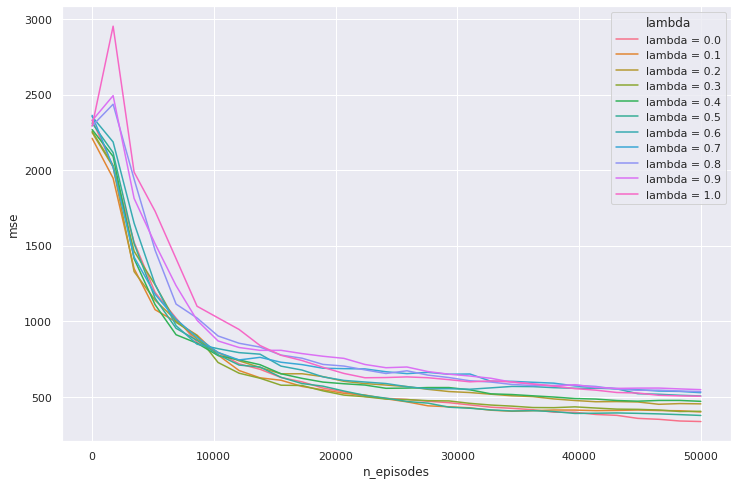

In [ ]:
mc = MC_Control(N_0=100, n_episodes=100000)
optimal_Q = mc.learn_q_value_function()

list_lambdas = np.linspace(0,1,11)
n_episodes = 50000
plot_mse(optimal_Q, n_episodes=n_episodes, list_lambdas=list_lambdas)

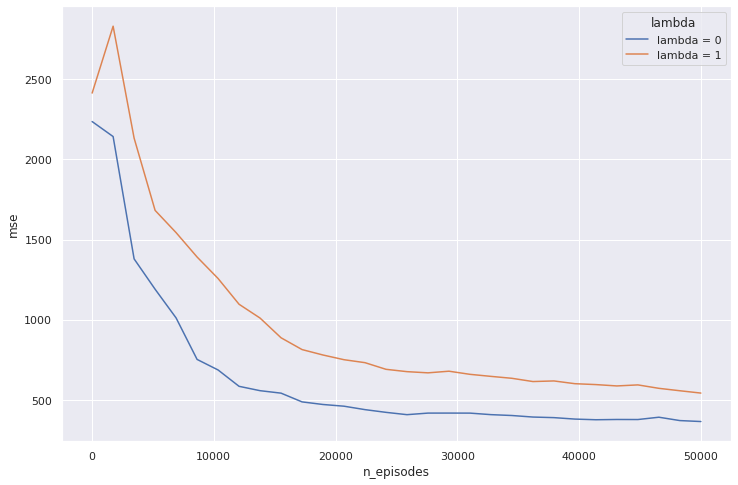

In [ ]:
list_lambdas = [0,1]
n_episodes = 50000
plot_mse(optimal_Q, n_episodes=n_episodes, list_lambdas=list_lambdas)

### Optimal policy

In [ ]:
def plot_opt_policy(lamb, n_episodes):
  sarsa_Q = SARSA(lamb=lamb, n_episodes=n_episodes, N_0=100)
  sarsa_Q.learn_q_value_function()
  df = pd.DataFrame(columns=['dealer_showing', 'player_score', 'best_action'])
  states = list(sarsa_Q.Q.keys())
  for i in range(len(states)):
    best_action = max(sarsa_Q.Q[states[i]], key=sarsa_Q.Q[states[i]].get)
    df.loc[i] = (states[i][0], states[i][1], best_action)
  
  df_pivot = df.pivot('player_score', 'dealer_showing', 'best_action')
  return df_pivot

plot_opt_policy(lamb=0, n_episodes=50000)

dealer_showing,1,2,3,4,5,6,7,8,9,10
player_score,,,,,,,,,,
1,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
2,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
3,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
4,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
5,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
6,stick,stick,stick,stick,stick,stick,stick,stick,hit,hit
7,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
8,stick,stick,stick,stick,stick,stick,stick,hit,stick,stick
9,stick,stick,hit,stick,stick,stick,stick,stick,hit,hit


In [ ]:
plot_opt_policy(lamb=0, n_episodes=100000)

dealer_showing,1,2,3,4,5,6,7,8,9,10
player_score,,,,,,,,,,
1,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
2,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
3,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
4,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
5,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
6,stick,stick,stick,stick,stick,stick,stick,stick,stick,hit
7,stick,stick,stick,stick,stick,stick,stick,stick,hit,stick
8,stick,stick,stick,stick,stick,stick,stick,stick,hit,hit
9,stick,stick,stick,stick,stick,stick,stick,hit,hit,hit


## Linear Value Approximation in Easy21

Value Approximation (VA) means exactly what it suggests. We are going to approximate the Q value function, rather than computing it for all the possible state-action pairs.

In order to approximate our Q value, we will need to reduce the range of possibilties. To do so, we have directly taken the intervals of the dealer's and player's scores provided by some expert of the game.

Remembering all the above approaches, we could see the Q value function as a lookup table for every state-action pair.

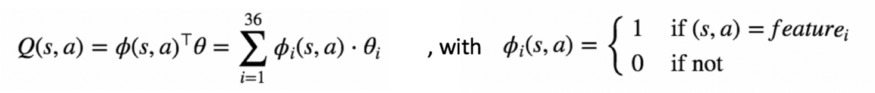

The Q value function is not a lookup table anymore, but a function depending on some weights. Now, we need to learn the best weights to get our approximation function as close as possible to the Optimal Q value function.

Therefore the update step function in the previous sections is modified to udate the weights θ of the linear function.

In [ ]:
class Value_Approximation():
    
    def __init__(self, lamb, n_episodes, alpha=0.01, epsilon=0.05):
        self.actions = ("hit", "stick")
        self.lamb = lamb
        self.n_episodes = n_episodes             
        self.features = self.create_features()
        self.theta = self.init_theta()                
        self.alpha = alpha
        self.epsilon = epsilon
        self.Q = self.init_to_zeros()
        
    def learn_q_value_function(self):
        for i in range(self.n_episodes):
            self.eligibilty_traces = np.zeros(36)
            easy21_game = Easy21()
            state = easy21_game.state.copy()    
            action = self.e_greedy_policy(state)
            
            while state != "terminal":      
                next_state, reward = deepcopy(easy21_game.step(state, action))
                
                if next_state == "terminal":
                    next_action = None
                    delta = self.compute_delta(state, action, next_state, next_action, reward)
                    
                else:   
                    next_action = self.e_greedy_policy(next_state)   
                    delta = self.compute_delta(state, action, next_state, next_action, reward)
                                                
                self.update_step(delta, state, action)
                
                action = next_action
                state = next_state
          
                     
        return None
    
    def init_theta(self):
             
        mu, sigma = 0, 0.1
        theta = np.random.normal(mu, sigma, 36)
        return theta
                
    def init_to_zeros(self):
        dealer_scores = np.arange(1, 11)
        player_scores = np.arange(1, 22)
        states = [(dealer_score, player_score) for player_score in player_scores for dealer_score in dealer_scores]       
        lookup_table = {}
        for state in states:
            lookup_table[state] = {"hit": 0, "stick": 0}  
            
        return lookup_table
    
    def create_features(self):
               
        dealer = [(1, 4), (4, 7), (7, 10)]
        player = [(1, 6), (4, 9), (7, 12), (10, 15), (13, 18), (16, 21)]
        actions = ["hit", "stick"]
        features = []
        for d in dealer:
            for p in player:
                for a in actions:
                    features.append((d, p, a))
        return features
 
    def update_step(self, delta, state, action):
        lookup_state = (state["dealer_score"], state["player_score"])
        index_associated_features = []
        for i, feature in enumerate(self.features):
            if (feature[0][0] <= lookup_state[0] <= feature[0][1]) and \
               (feature[1][0] <= lookup_state[1] <= feature[1][1]) and \
               (action == feature[2]):                
                index_associated_features.append(i)
                
        for i in index_associated_features:
            self.eligibilty_traces[i] = self.lamb * self.eligibilty_traces[i] + 1
            self.theta[i] = self.theta[i] + self.alpha * delta * self.eligibilty_traces[i]  
            
        return None
    
    def compute_delta(self, state, action, next_state, next_action, reward):
        lookup_state = (state["dealer_score"], state["player_score"])
        if next_state == "terminal":
            delta = reward - self.phi(lookup_state, action)
        else:
            next_lookup_state = (next_state["dealer_score"], next_state["player_score"])
            delta = reward + self.phi(next_lookup_state, next_action) - self.phi(lookup_state, action)
        return delta
    

    def phi(self, state, action):
        index_associated_features = []
        for i, feature in enumerate(self.features):
            if (feature[0][0] <= state[0] <= feature[0][1]) and \
               (feature[1][0] <= state[1] <= feature[1][1]) and \
               (action == feature[2]):
                index_associated_features.append(i)
        q_value = np.sum(np.take(self.theta, index_associated_features, axis=0))
        return q_value   
    
    def random_policy(self):
        action = random.choice(self.actions)       
        return action

    def e_greedy_policy(self, state):
        if self.epsilon > random.uniform(0, 1): 
            action = random.choice(self.actions)
        else:  
            action = self.get_action_w_max_value(state)
            
        return action
    
    def get_action_w_max_value(self, state):
        lookup_state = (state["dealer_score"], state["player_score"])
        if self.phi(lookup_state, "hit") == self.phi(lookup_state, "stick"):
            return self.random_policy()
        else:
            if self.phi(lookup_state, "hit") > self.phi(lookup_state, "stick"):
                return "hit"
            else:
                return "stick"

In [ ]:
va = Value_Approximation(lamb=0.9, n_episodes=100)
va.learn_q_value_function()

In [ ]:
def plot_va_Q(n_episodes, lamb=0.9):
  va = Value_Approximation(lamb=lamb, n_episodes=n_episodes)
  va.learn_q_value_function()

  fig = plt.figure(figsize = (20,10))
  ax = fig.gca(projection='3d')

  dealer_showing = np.arange(1, 11)
  player_score = np.arange(1, 22)
  dealer_showing, player_score = np.meshgrid(dealer_showing, player_score)

  Q = {}
  for state in va.Q.keys():
    for action in va.actions:
      Q[state] = {'hit': va.phi(state, 'hit'), 'stick': va.phi(state, 'stick')}
  
  max_Q = np.ndarray(shape=(21,10))
  for state in va.Q:
    max_Q[state[1]-1][state[0]-1] = max(Q[state].values())
  
  surf = ax.plot_surface(dealer_showing, player_score, max_Q, cmap=cm.coolwarm, linewidth=0, antialiased=False)

  ax.set_zlim(-1.01, 1.01)
  ax.zaxis.set_major_locator(LinearLocator(10))
  ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

  plt.xlabel('Dealer showing', fontsize=12)
  plt.ylabel('Player score', fontsize=12)
  plt.title('Optimal Q Value Function', fontsize=16)

  plt.xticks(np.arange(1,11))
  plt.yticks(np.arange(1,22))

  fig.colorbar(surf, shrink=0.5, aspect=5)
  plt.show()

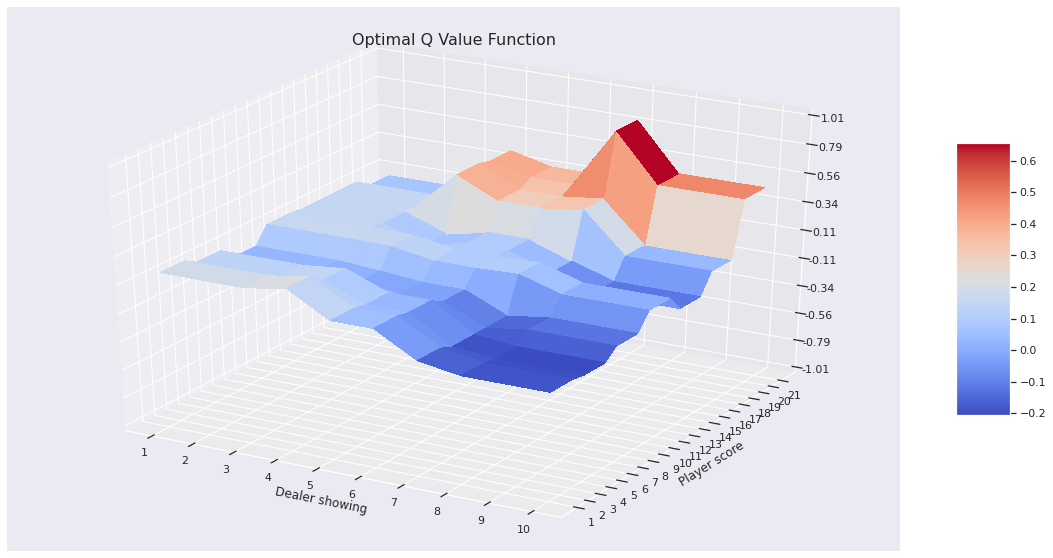

In [ ]:
plot_va_Q(n_episodes=10000)

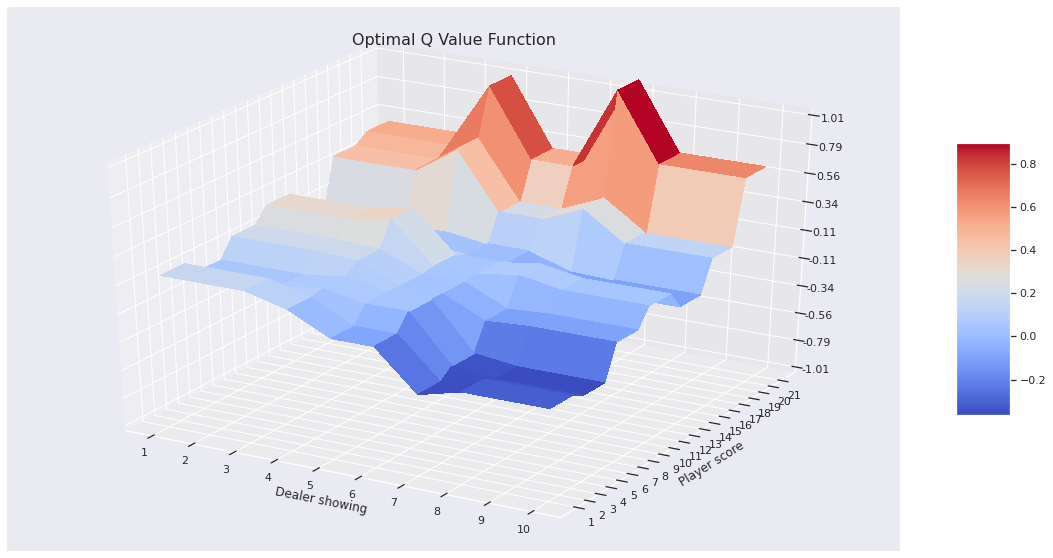

In [ ]:
plot_va_Q(n_episodes=100000)